In [59]:
import numpy as np
from math import sin, cos, tan, pi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [60]:
#Raw Voltage Across Shunt Resistor Data vs Frequency
#NaN was manually placed as data point was missing.
#Voltage in mV, frequency MHz
voltage_shunt = [5.002, 3.021, 3.681, 5.989, 6.879, 4.34, 5.006, 7.971, 8.961, 5.663, 8.976, 13.908, np.nan, 18.9, 16.346, 10.58, 1.5, 0.676]
frequency = [1.2, 1.2, 1.4, 1.4, 1.6, 1.6, 1.8, 1.8, 2, 2, 3, 3, 4,4, 3.5, 3.5, 0.5, 0.5]
error = 0.002 
#Sorting voltage frequency S.T. lower voltage is first for each frequency
def sort_voltages(voltages): 
    for l in range(0, len(voltages)//2):
        i = l*2
        if voltages[i] is np.nan or voltages[i+1] is np.nan:
            continue
        t1 = min(voltages[i], voltages[i+1])
        t2 = max(voltages[i], voltages[i+1])
        voltages[i] = t1 
        voltages[i+1] = t2
sort_voltages(voltage_shunt)
#Splitting data into two lines of voltage vs frequency
x1, y1= voltage_shunt[::2], frequency[::2]
x2, y2= voltage_shunt[1::2], frequency[1::2]

#Repeating for reverse polarity
#Removed -0.356 mV / .2 MHz frequency - doesn't fit / possibly zero field?
reverse_voltage_shunt = [-1.425,-1.68,-5.902,-8.37,-10.84,-7.52,-9.178,-13.293,-10.832,-15.756]
reverse_frequency= [0.2,0.2,1.5,1.5,2,2,2.5,2.5,3,3]
sort_voltages(reverse_voltage_shunt)
x3, y3= reverse_voltage_shunt[::2], reverse_frequency[::2]
x4, y4= reverse_voltage_shunt[1::2], reverse_frequency[1::2]


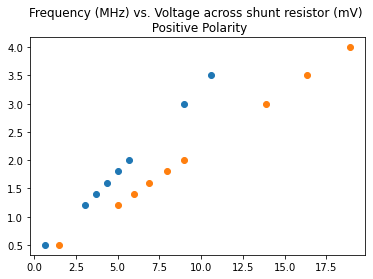

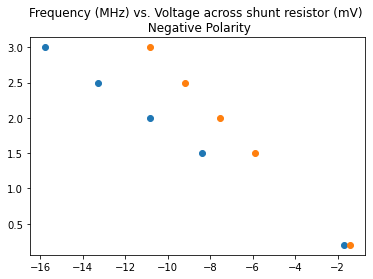

In [61]:
plt.title("Frequency (MHz) vs. Voltage across shunt resistor (mV) \n Positive Polarity")
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.figure()
plt.title("Frequency (MHz) vs. Voltage across shunt resistor (mV) \n Negative Polarity")


plt.scatter(x3, y3)
plt.scatter(x4, y4)



In [100]:
#Assuming constant error of .002 mV
#Naively calculate slope for each line
#Use naive slope to propagate error onto y variable
#Calculate least squared regression. Given we are assuming fixed error on x
#this should give same result as simple least squared

#Then need to calculate error see https://en.wikipedia.org/wiki/Weighted_least_squares
#For forumulas
def naive_slope(x, y):
    
    pars, cov = curve_fit(lambda x, m, y0 : m*x+y0, x, y, p0=[1,1])  
    slope = pars[0]
    return slope, cov[0,0]**(1/2)
    
#Error estimate based on naive slope prediction and its error as well as observation error in x propagated to y
def y_err(x, y):
    slope_estimate, err = naive_slope(x,y)
    #yerr = ((.002 * slope_estimate)**2 + (err*x)**2)**(1/2)  * np.ones(x.shape)
    yerr = ((.002 * slope_estimate)**2 + (err*x)**2)**(1/2)  * np.ones(x.shape)
    return yerr
def error_lslf(x, y):
    x = np.array(x)
    y = np.array(y)
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    
    X = np.zeros(shape=(len(x), 2))
    X[:, 0] = x
    X[:, 1] = 1
    err = y_err(x,y)
    W = np.diag(1/err**2)
    B = np.linalg.inv(X.transpose()@W@X)@(X.transpose()@W@y)
    mw, y0w = B
    errors = np.linalg.inv(X.transpose() @ W @ X)
    err_mw = errors[0,0]**(1/2)
    err_y0w = errors[1,1]**(1/2)
    
    #print(err_y0w)
    return mw, err_mw, y0w,err_y0w
    
print(error_lslf(x1, y1))
print(error_lslf(x2, y2))
print(error_lslf(x3, y3))
print(error_lslf(x4, y4))


(0.3028085226577366, 0.0071797533353050585, 0.2874077328481919, 0.04324870149556668)
(0.20153082563699398, 0.002531568438623422, 0.19755760102782816, 0.027396936935704577)
(-0.19869541069551766, 0.0038896336158445125, -0.14482427281045496, 0.041672723512502716)
(-0.29771080424952845, 0.008488800238026601, -0.23558642401487084, 0.06413247214035653)


In [101]:
def simple_lsr(x, y):
    x = np.array(x)
    y = np.array(y)
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    pars, cov = curve_fit(lambda x, m, y0 : m*x+y0, x, y, p0=[1,1])  
    mean, sd = pars
    mean_err,sd_err  = np.sqrt(np.diag(cov))
    return mean, mean_err, sd, sd_err

print(simple_lsr(x1, y1))
print(simple_lsr(x2, y2))
print(simple_lsr(x3, y3))
print(simple_lsr(x4, y4))


(0.30281499371056486, 0.0006776961497154371, 0.2873788398281262, 0.004091535147311155)
(0.20152684028705256, 0.0004961538377585633, 0.19759137075636685, 0.005415252199645271)
(-0.19890040610080914, 0.0014593379200265834, -0.14657747605366125, 0.01618931746579)
(-0.2978450711744928, 0.0021589689078991754, -0.23639712905930996, 0.016582864131461632)


In [102]:
#Weighted LSRL
def adjusted_concat(x1,y1, x2, y2):
    x1 = np.array(x1)
    y1 = np.array(y1)
    x2 = np.array(x2)
    y2 = np.array(y2)
    m, _, y0, _ = simple_lsr(x1, y1)
    m2, _, y02, _ = simple_lsr(x2, y2)
    x= np.concatenate((x1, -1* np.array(x2)))
    y =  np.concatenate((y1-y0, y2-y02))
    return x,y

#print(simple_lsr(x85, y85))
#print(simple_lsr(x87, y87))
data_87 = adjusted_concat(x1,y1, x4, y4)
adj_87w = error_lslf(*data_87)
data_85 = adjusted_concat(x2,y2, x3, y3)
adj_85w =error_lslf(*data_85)
print(adj_85w)
print(adj_87w)

(0.20054000490459922, 0.0021455185061772394, 9.229715877268063e-05, 0.02301418441948502)
(0.29943341683402114, 0.00531426621188645, 0.006613001893107651, 0.035206045245302076)


In [103]:
#Simple LSR Combing polarities

#Function removes ambient field bias by subtracting out intercepts before
#combining negative and positive fields
def adjusted_concat(x1,y1, x2, y2):
    x1 = np.array(x1)
    y1 = np.array(y1)
    x2 = np.array(x2)
    y2 = np.array(y2)
    m, _, y0, _ = simple_lsr(x1, y1)
    m2, _, y02, _ = simple_lsr(x2, y2)
    x= np.concatenate((x1, -1* np.array(x2)))
    y =  np.concatenate((y1-y0, y2-y02))
    return x,y

#print(simple_lsr(x85, y85))
#print(simple_lsr(x87, y87))
data_87 = adjusted_concat(x1,y1, x4, y4)
adj_87 = simple_lsr(*data_87)
data_85 = adjusted_concat(x2,y2, x3, y3)
adj_85 =simple_lsr(*data_85)
print(adj_85)
print(adj_87)

(0.20060719103542157, 0.0009260113974840049, -0.00047468247472726155, 0.010166532388094314)
(0.29948395968302566, 0.0017404826755106262, 0.006352828398506918, 0.011691317562706218)


In [104]:
#Breit-Rabi Predictions
#v/B = 2.799 / (2I+1) MHz/ G
#B = I * 4.414138 G / A
#v  = I /  (2I+1) * 4.414138 G/ A * 2.799 MHz / G
#v = I / (2I+1) * 12.355 MHz / A
#V = IR where R = I (10 mV/ A)
#I = V/ 10 * A / mV
#v = V / (2I+1) * 1.2355 MHz / mV


#v_85 = 0.2059 MHz / mV * V
#v_87 = 0.3089 MHz / mV * V
cons_85 = 0.2059
cons_87 = 0.3089

def error(f, cons):
    abs_err = abs(f[0] - cons)
    p_err = abs_err / cons
    print(f[0], cons, f[1], abs_err, p_err*100)

error(adj_85, cons_85)
error(adj_87, cons_87)


error(adj_85w, cons_85)
error(adj_87w, cons_87)

0.20060719103542157 0.2059 0.0009260113974840049 0.005292808964578427 2.5705725908588763
0.29948395968302566 0.3089 0.0017404826755106262 0.00941604031697435 3.0482487267641143
0.20054000490459922 0.2059 0.0021455185061772394 0.005359995095400777 2.60320305750402
0.29943341683402114 0.3089 0.00531426621188645 0.00946658316597887 3.064610931038805


In [90]:
#3 Determine Nuclear Spins 

#v = B * 2.799 / (2I+1) MHz/ G

#v85/v87=(2I87+1) / (I85+1) 

#Minimize these errors
#v85/v87 = (2I87+1) / (I85+1) = 0.6758
#m_85 = 1.2355 / (2I85+1) = 0.2024
#m_87 = 1.2355 / (2I87+1) = 0.3089
#=>
# 1.2355 = .2024 + .2024 * 2 * I85
# 1.2355 = .3089 + .3089 * 2 * I87
# 2*I87+1 = (I85 + 1) * .6758

m85 = adj_85[0]
m87 = adj_87[0]
c = 1.2355
r = m85/m87
max_spin = 40 * 2 #technically double max spin, as number gets divided by 2

#Essentially do min squared error on 3 parameters

b = np.array([1-r, c-m85, c-m87])
A = np.array([[2 *r, -2], [2 * m85, 0], [0, 2 * m87]])
def error(pair):
    x, y = pair
    return np.linalg.norm(b - A@np.array([x,y]).T)
    

pairs = [y for x in [[(x/2, y/2) for y in range(0, max_spin)] for x in range(0,max_spin)] for y in x]
pairs.sort(key= lambda x:error(x))
p_r = (2*pairs[0][1] + 1)/(2*pairs[0][0]+1)

print("Best Fit for (I85, I87): "+str(pairs[0]))
print("Predicted ratio: " + str(p_r))
print("Observed ratio: " + str(r))

Best Fit for (I85, I87): (2.5, 1.5)
Predicted ratio: 0.6666666666666666
Observed ratio: 0.6698428565180738


In [9]:
#Using only ratio and half integer expectation
def error(pair):
    x, y = pair
    return abs(r - (2 * y +1) / (2 *x + 1))
    

pairs = [y for x in [[(x/2, y/2) for y in range(0, max_spin)] for x in range(0,max_spin)] for y in x]
pairs.sort(key= lambda x:error(x))
p_r = (2*pairs[0][1] + 1)/(2*pairs[0][0]+1)
print("Best Fit(s) for (I85, I87): "+str(pairs[0]))
print("Predicted ratio: " + str(p_r))
print("Observed ratio: " + str(r))

Best Fit(s) for (I85, I87): (18.0, 12.0)
Predicted ratio: 0.6756756756756757
Observed ratio: 0.6758033915953846


In [10]:
#Using fit to data and integer expectation
def error(pair):
    x, y = pair
    return abs(2 *x * m85 - c + m85) +abs(2 *y * m87 - c + m87)
pairs = [y for x in [[(x/2, y/2) for y in range(0, max_spin)] for x in range(0,max_spin)] for y in x]
pairs.sort(key= lambda x:error(x))
p_r = (2*pairs[0][1] + 1)/(2*pairs[0][0]+1)
print("Best Fit(s) for (I85, I87): "+str(pairs[0]))
print("Predicted ratio: " + str(p_r))
print("Observed ratio: " + str(r))

Best Fit(s) for (I85, I87): (2.5, 1.5)
Predicted ratio: 0.6666666666666666
Observed ratio: 0.6758033915953846


In [11]:
#Using fit to data w/o integer expectation.
pairs = [y for x in [[(x/2, y/2) for y in range(0, max_spin)] for x in range(0,max_spin)] for y in x]
pairs[0] =  ((c- m85)/2/m85,  (c- m87)/2/m87)
p_r = (2*pairs[0][1] + 1)/(2*pairs[0][0]+1)

errors = c / np.array(pairs[0])**2 * np.array([adj_85[1], adj_87[1]])/2
print("Best Fit(s) for (I85, I87): "+str(pairs[0]))
print("Expected Errors: " + str(errors))

Best Fit(s) for (I85, I87): (2.552240990510871, 1.5627148133537025)
Expected Errors: [0.00187967 0.00044027]


In [12]:
#Lets calculate the magnitude of the magnetic field
#First lets get frequency offsets
#v = 2.799 /(2I +1) * B 
#v = 2.799 / (2I+1) * Bapplied + 2.799 / (2I+1) * Bambient
#v_0 * (2I+1) / 2.799 G / MHz = B_ambient
data = [simple_lsr(x1, y1), simple_lsr(x2, y2), simple_lsr(x3, y3), simple_lsr(x4, y4)]
data = np.array(data)
data = data[:, 2:]
I = (2 * np.array([3/2, 5/2, 5/2, 3/2]) + 1) / 2.799
B = np.zeros(data.shape)
B[:, 0] = data[:,0] * I
B[:, 1] = data[:,1] * I
B = np.abs(B)
print(B)
wavg = np.sum((1/B[:,1]**2) * B[:, 0])/np.sum(1/B[:,1]**2)
werr = (1/np.sum(1/B[:,1]**2))**(1/2)
print(wavg, werr)




[[0.41068787 0.00584714]
 [0.42356135 0.01160826]
 [0.31420681 0.03470379]
 [0.33783084 0.02369827]]
0.4077779581621423 0.005045544059023304


In [13]:
#Alrighty. Lets calculate magnitude of ambient magnetic field but this time 
#from zero current measurements
#Note, small number of data points means using stastics for error (as done below)
#is questionable.
v = np.array([.189, .289])
I = (2 * np.array([5/2, 3/2]) + 1) / 2.799
B2 = v * I
B_avg = np.mean(B2)
B_std = np.std(B2)
print(B_avg, B_std)

0.4090746695248303 0.00392997499106823


In [14]:
#Zero Field Resonance. My fav :D
f = [.2, .2, .5, .5, 1, 1]
v = np.abs(np.array([-.195, -0.356, -.954, -2.595, -4.251, -9.43]))
x1,y1 = v[::2], f[::2]
x2,y2 = v[1::2], f[1::2]

#Lets predict m field real quick
#B = I * 4.414138 G / A
#I = V/ 10 * A / mV

v1_pred = np.array(x1) *adj_85[0] + adj_85[2]
v2_pred = np.array(x2) *adj_87[0] + adj_87[2]

#B = I * 4.414138 G / A

#Expected B Field at this current
B = v * .414138  - B_avg
print(B)

#Which suggests (-.954 mV, .5 MHz) is a zero frequency


[-0.32831776 -0.26164154 -0.01398702  0.66561344  1.35142597  3.49624667]


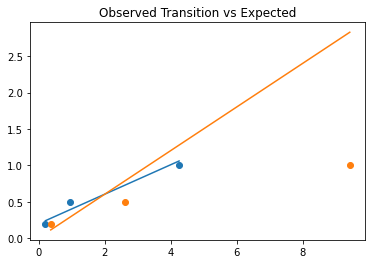

In [15]:
plt.title("Observed Transition vs Expected")
plt.scatter(x1, y1)
plt.plot(x1, v1_pred)
plt.scatter(x2, y2)
plt.plot(x2, v2_pred)

#Graph suggests 9 mV, 3 mV, .9 mV are anomolous (zero frequencies?)

In [ ]:
#50 ms to get from opaque (no optical pumping) to 1/e baseline (optically pumped)
#